<a href="https://colab.research.google.com/github/AnnaPakir/pizza_2/blob/main/pizza_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение переноса обучения

<u>Цель: </u> исследовать возможности переноса обучения для решения целевой задачи, выбранной изначально для выполнения практических работ.

Эксперимент ставился на тех же данных, которые были использованы в лаб №2 для создания полностью связанной нейроннной сети.

VGG16 выбрана, так как она широко используется, имеет предобученные веса в torchvision, и её полносвязная часть легко адаптируется под прошлые эксперименты.

## Часть 1. Загрузка библиотек

In [ ]:
import zipfile
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import torch.optim as optim


In [ ]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

Подготовка данных

Был использовано подмножество набора данных Food-101. (Bossard, Lukas, Matthieu Guillaumin и Luc Van Gool. "Food-101 – Mining Discriminative Components with Random Forests") https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza Изображения находятся в папке "img" в двух папках, "pizza" и "not_pizza", в каждой папке 983 файла с изображениями.

In [ ]:
# раскроем архив
zip_file_path = '/content/pizza.zip'
extract_to_folder = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_folder)

In [ ]:
# Путь к набору данных
data_dir = '/content/pizza_not_pizza'

# Загружаем данные
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Определение размеров выборок
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

print(f'Количество обучающих изображений: {train_size}')
print(f'Количество валидационных изображений: {val_size}')
print(f'Количество тестовых изображений: {test_size}')

# Разделение на train, val и test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Применение трансформаций к датасетам
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

Количество обучающих изображений: 1376
Количество валидационных изображений: 294
Количество тестовых изображений: 296


Прямое использование модели (Parameter Transfer)

Применяем VGG16, настроенную для бинарной классификации, с весами, предварительно обученными на наборе данных ImageNet, и оцениваем её эффективность на задаче распознавания «пицца/не пицца» без дальнейшего обучения. Такой подход позволяет понять, насколько хорошо предобученная модель способна адаптироваться к новой задаче.

In [ ]:
# загружаем модель, модифицируем конец модели
class VGG16Adapted(nn.Module):
    def __init__(self):
        super(VGG16Adapted, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def validate_model(model, data_loader, criterion, dataset_type="Validation"):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss /= len(data_loader)
    accuracy = 100 * correct / total
    print(f'{dataset_type} Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy, all_preds, all_labels

In [ ]:
def plot_confusion_matrix(preds, labels, title, classes=['Not Pizza', 'Pizza']):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Adapted().to(device)
criterion = nn.BCELoss()

In [ ]:
# Тестирование на валидационной выборке
val_loss, val_accuracy, val_preds, val_labels = validate_model(model, val_loader, criterion, "Validation")

Validation Loss: 0.6939, Accuracy: 50.34%


Test Loss: 0.6972, Accuracy: 48.99%


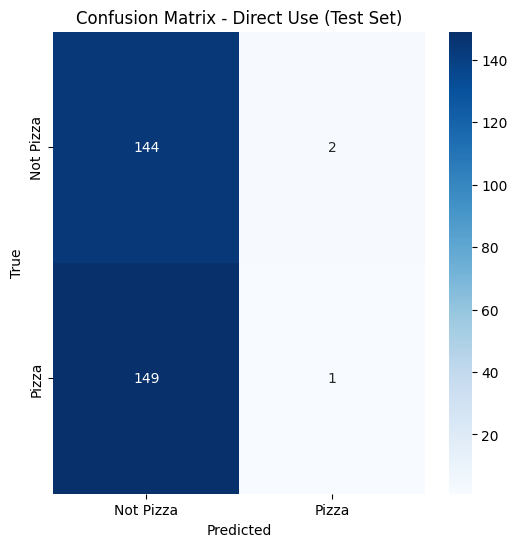

In [ ]:
test_loss, test_accuracy, test_preds, test_labels = validate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_preds, test_labels, "Confusion Matrix - Direct Use (Test Set)")

Модель фактически определила все данные как не пицца. Требуется обучение

##Использование структуры модели с обучением на новых данных (Transfer Learning for Relational Domains)

Берётся архитектура VGG16 с нуля, без использования предобученных весов, и модель полностью обучается только на вашем наборе данных «пицца/не пицца». Такой опыт позволяет оценить, насколько сама структура VGG16 эффективна для данной задачи, независимо от внешнего опыта.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}')
        val_loss, accuracy, _, _ = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)
    return train_losses, val_losses, val_accuracies

In [ ]:
def plot_training_curves(train_losses, val_losses, val_accuracies, title_prefix):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Adapted().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10

In [ ]:
# Обучение
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.4380
Validation Loss: 0.3428, Accuracy: 89.46%
Epoch [2/10], Train Loss: 0.2752
Validation Loss: 0.2522, Accuracy: 93.20%
Epoch [3/10], Train Loss: 0.2138
Validation Loss: 0.2692, Accuracy: 90.82%
Epoch [4/10], Train Loss: 0.1605
Validation Loss: 0.1748, Accuracy: 95.92%
Epoch [5/10], Train Loss: 0.1400
Validation Loss: 0.2358, Accuracy: 90.48%
Epoch [6/10], Train Loss: 0.1229
Validation Loss: 0.2166, Accuracy: 90.14%
Epoch [7/10], Train Loss: 0.0899
Validation Loss: 0.1737, Accuracy: 92.86%
Epoch [8/10], Train Loss: 0.0906
Validation Loss: 0.1795, Accuracy: 91.84%
Epoch [9/10], Train Loss: 0.0689
Validation Loss: 0.1842, Accuracy: 92.18%
Epoch [10/10], Train Loss: 0.0719
Validation Loss: 0.2233, Accuracy: 91.50%


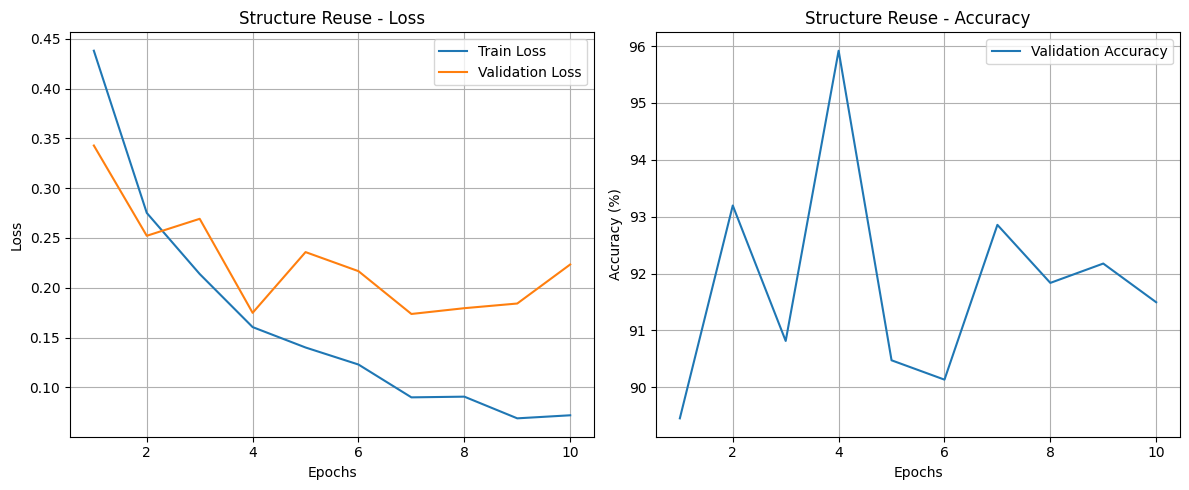

In [ ]:
# Построение графиков
plot_training_curves(train_losses, val_losses, val_accuracies, "Structure Reuse")

Модель почти сразу обучается, а потом начинает переобучаться

Test Loss: 0.2730, Accuracy: 89.53%


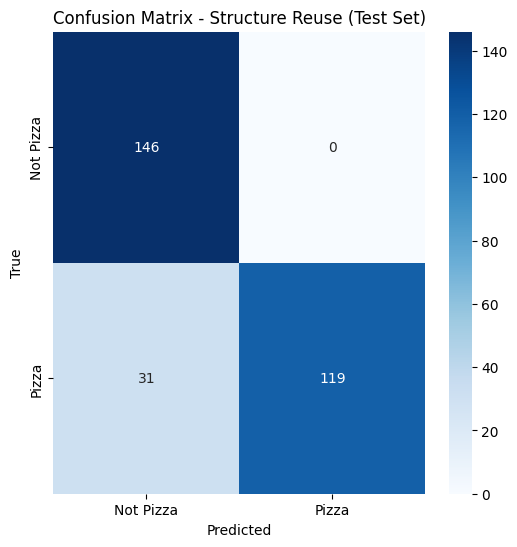

In [ ]:
test_loss, test_accuracy, test_preds, test_labels = validate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_preds, test_labels, "Confusion Matrix - Structure Reuse (Test Set)")

<u>Вывод по данной части</u> Модель хорошо обучилась почти сразу, даже появились признаки переобучения. Модель идеально разпознает положительный класс, но во втором классе делает 31 ошибку

##Использование модели как фиксированного метода извлечения признаков (Feature Representation Transfer)

Свёрточные слои VGG16, заранее обученные на ImageNet, используются как экстрактор признаков, и их параметры остаются неизменными (заморожены). Далее, поверх сверточной части добавляется полносвязная часть (как в лабораторной работе №2), которую уже обучают на собственных данных «пицца/не пицца». Таким образом, только полносвязные слои подбирают параметры под новую задачу.

In [ ]:
class VGG16Adapted(nn.Module):
    def __init__(self):
        super(VGG16Adapted, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Adapted().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
num_epochs = 10

In [ ]:
# Обучение
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.4072
Validation Loss: 0.2925, Accuracy: 93.20%
Epoch [2/10], Train Loss: 0.2243
Validation Loss: 0.2176, Accuracy: 92.86%
Epoch [3/10], Train Loss: 0.1480
Validation Loss: 0.1989, Accuracy: 93.20%
Epoch [4/10], Train Loss: 0.0932
Validation Loss: 0.1939, Accuracy: 93.20%
Epoch [5/10], Train Loss: 0.0719
Validation Loss: 0.1849, Accuracy: 93.88%
Epoch [6/10], Train Loss: 0.0617
Validation Loss: 0.1860, Accuracy: 94.22%
Epoch [7/10], Train Loss: 0.0439
Validation Loss: 0.1576, Accuracy: 93.20%
Epoch [8/10], Train Loss: 0.0510
Validation Loss: 0.1436, Accuracy: 94.90%
Epoch [9/10], Train Loss: 0.0307
Validation Loss: 0.1427, Accuracy: 94.22%
Epoch [10/10], Train Loss: 0.0269
Validation Loss: 0.1710, Accuracy: 94.56%


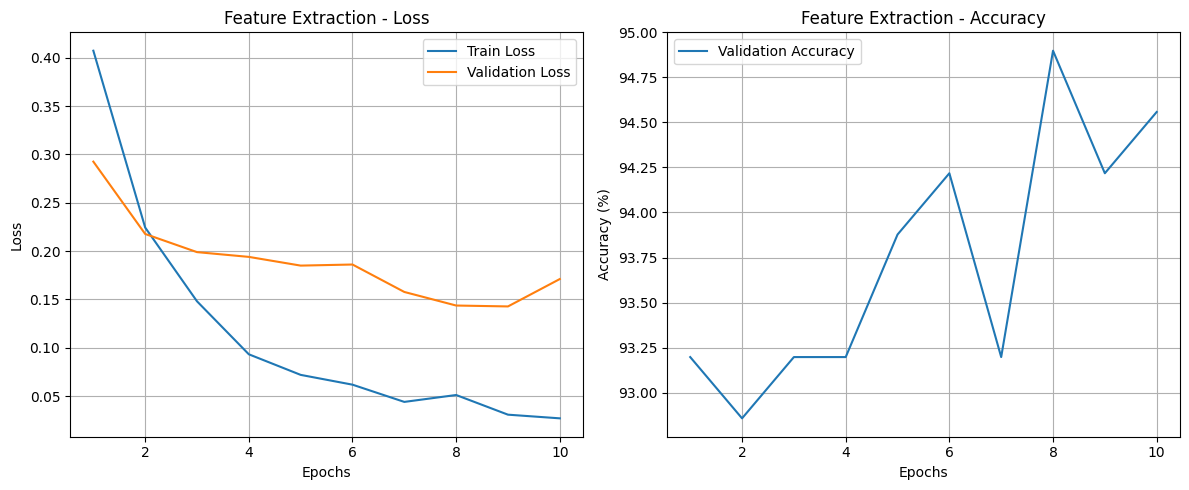

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies, "Feature Extraction")

Test Loss: 0.2238, Accuracy: 92.23%


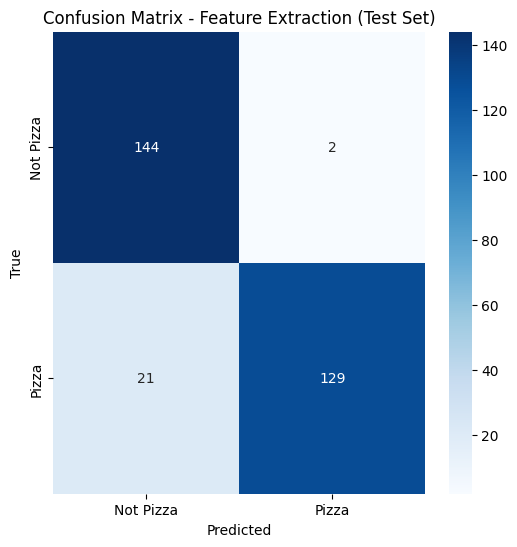

In [ ]:
test_loss, test_accuracy, test_preds, test_labels = validate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_preds, test_labels, "Confusion Matrix - Feature Extraction (Test Set)")

<u>Вывод по данной части</u> Модель обучилась лучше всего,хотя тоже видны признаки переобучения.

##Тонкая настройка параметров (Instance-based Transfer Learning)

Берём уже обученную на ImageNet VGG16, заменяем её полносвязные слои на аналогичную структуру из лабораторной работы №2, и затем тонко настраиваем всю модель на задаче «пицца/не пицца», используя небольшой шаг обучения (learning rate)

In [ ]:
class VGG16Adapted(nn.Module):
    def __init__(self):
        super(VGG16Adapted, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Adapted().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])
num_epochs = 10


In [ ]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.4146
Validation Loss: 0.2829, Accuracy: 94.22%
Epoch [2/10], Train Loss: 0.2316
Validation Loss: 0.2186, Accuracy: 95.58%
Epoch [3/10], Train Loss: 0.1369
Validation Loss: 0.1953, Accuracy: 95.92%
Epoch [4/10], Train Loss: 0.1018
Validation Loss: 0.1732, Accuracy: 94.56%
Epoch [5/10], Train Loss: 0.0912
Validation Loss: 0.1773, Accuracy: 94.22%
Epoch [6/10], Train Loss: 0.0590
Validation Loss: 0.1575, Accuracy: 94.22%
Epoch [7/10], Train Loss: 0.0443
Validation Loss: 0.1407, Accuracy: 95.58%
Epoch [8/10], Train Loss: 0.0410
Validation Loss: 0.1450, Accuracy: 95.58%
Epoch [9/10], Train Loss: 0.0355
Validation Loss: 0.1342, Accuracy: 95.24%
Epoch [10/10], Train Loss: 0.0315
Validation Loss: 0.1682, Accuracy: 94.56%


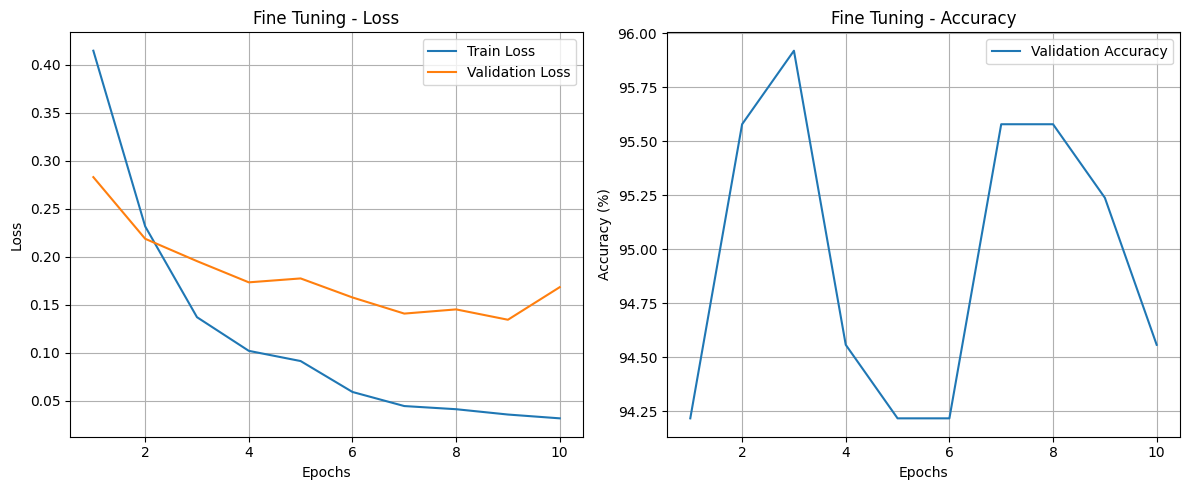

In [ ]:
plot_training_curves(train_losses, val_losses, val_accuracies, "Fine Tuning")

Test Loss: 0.1988, Accuracy: 91.22%


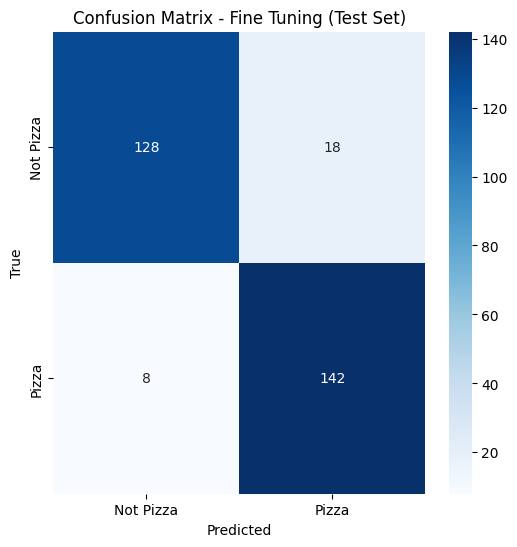

In [ ]:
test_loss, test_accuracy, test_preds, test_labels = validate_model(model, test_loader, criterion, "Test")
plot_confusion_matrix(test_preds, test_labels, "Confusion Matrix - Fine Tuning (Test Set)")

<u>Вывод по данной части</u> Модель хорошо обучилась, видны также признаки переобучения.

## Вывод

Перенос обучения очень сильно сказался на метриках. Модели получали 80-90 % метрик уже на 1-2 эпохе, а дальще начаналось переобучение. Эксперимент показал, что миспользуемая модель лучше подходит для данных, может использоваться с минимальным обучением.

| Вид переноса  | Accuracy |
| --- | --- |  
| Parameter Transfer |  48,99 % |
| Transfer Learning for Relational Domains |  89,53 % |
| Feature Representation Transfer |   92,23 % |
| Instance-based Transfer Learning |   91,22 % |

Лучше всего показала себя Feature Representation Transferс зпмороженными сверточными слоями и размороженными полносвязными слоями.